In [1]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import BlackmanWaveform, RampWaveform
from pulser.devices import MockDevice

import numpy as np
import qutip
import matplotlib.pyplot as plt

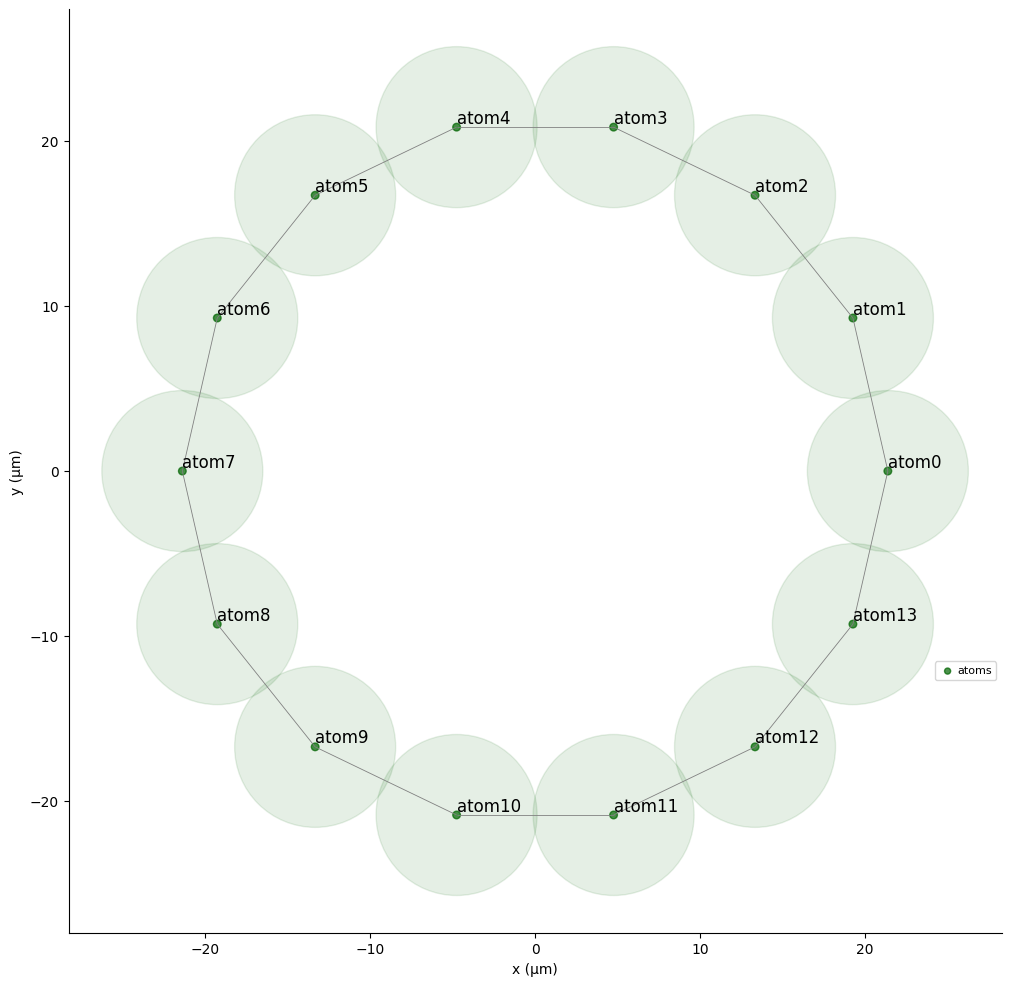

In [10]:
L = 14

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000

R_interatomic = MockDevice.rydberg_blockade_radius(U) 
coords = (R_interatomic / (2 * np.tan(np.pi / L)) * np.array([(np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L)) for theta in range(L)]))

reg = Register.from_coordinates(coords, prefix='atom')

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

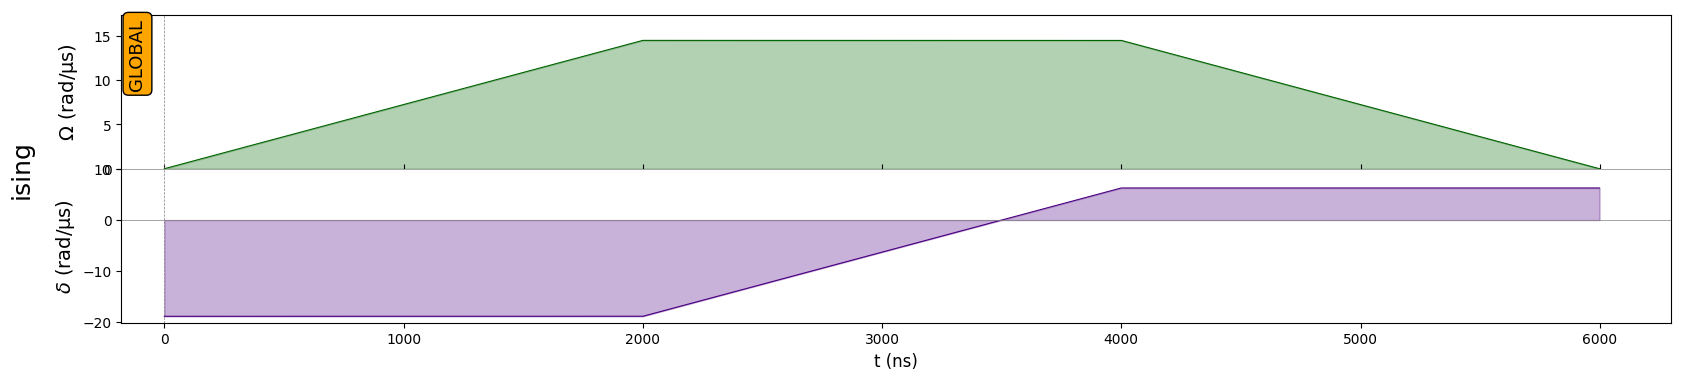

In [11]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0)

seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

seq.draw()

In [12]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(progress_bar=True)

10.0%. Run time:   0.56s. Est. time left: 00:00:00:05
20.0%. Run time:   1.15s. Est. time left: 00:00:00:04
30.0%. Run time:   1.81s. Est. time left: 00:00:00:04
40.0%. Run time:   2.71s. Est. time left: 00:00:00:04
50.0%. Run time:   3.64s. Est. time left: 00:00:00:03
60.0%. Run time:   4.70s. Est. time left: 00:00:00:03
70.0%. Run time:   5.82s. Est. time left: 00:00:00:02
80.0%. Run time:   6.92s. Est. time left: 00:00:00:01
90.0%. Run time:   7.94s. Est. time left: 00:00:00:00
Total run time:   8.85s


In [13]:
results.states[23]

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-7.805050027343778e-20+3.4129076826535735e-20j)
  (1, 0)	(2.0688560318548167e-18-1.2918637148071087e-18j)
  (2, 0)	(2.0688560318548074e-18-1.2918637148071027e-18j)
  (3, 0)	(-4.1245931921670734e-17+3.8384397539565015e-17j)
  (4, 0)	(2.0688560318548117e-18-1.2918637148071085e-18j)
  (5, 0)	(-5.4549602964003015e-17+4.532333278879971e-17j)
  (6, 0)	(-4.124593192167069e-17+3.8384397539564916e-17j)
  (7, 0)	(7.623800453168622e-16-1.0480805773090079e-15j)
  (8, 0)	(2.0688560318548205e-18-1.2918637148071135e-18j)
  (9, 0)	(-5.300024404782625e-17+4.52760750573285e-17j)
  (10, 0)	(-5.454960296400291e-17+4.532333278879961e-17j)
  (11, 0)	(1.0383274268434215e-15-1.2671557715547958e-15j)
  (12, 0)	(-4.1245931921670796e-17+3.838439753956507e-17j)
  (13, 0)	(1.0383274268434194e-15-1.267155771554797e-15j)
  (14, 0)	(7.623800453168612e-16

<BarContainer object of 33 artists>

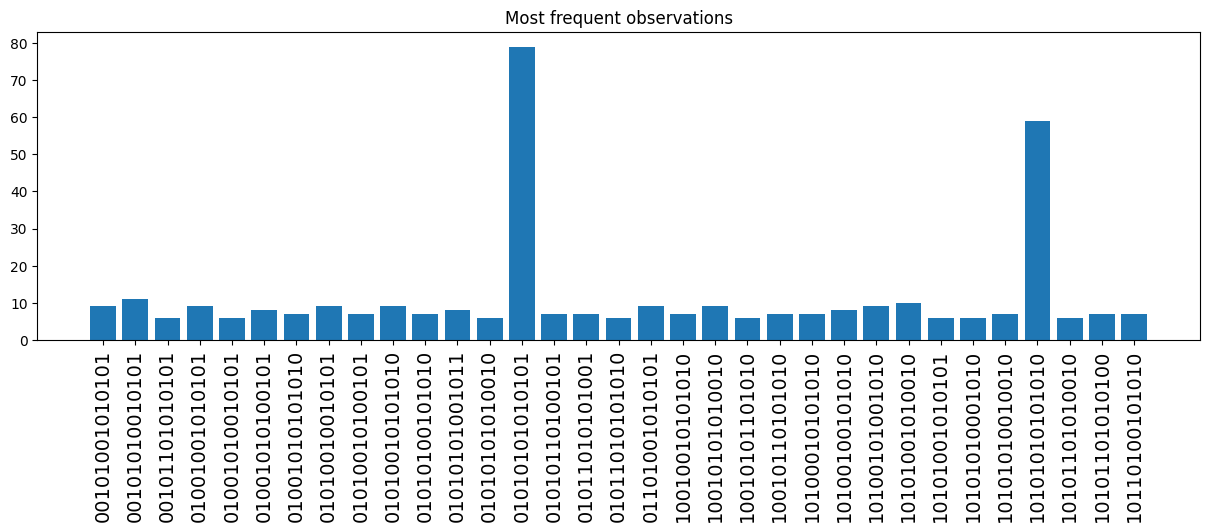

In [14]:
counts = results.sample_final_state(N_samples=1000)

large_counts = {k: v for k, v in counts.items() if v > 5}

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90, fontsize=14)
plt.title('Most frequent observations')
plt.bar(large_counts.keys(), large_counts.values())

In [15]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)

magn_list = [magnetization(j, L) for j in range(L)]

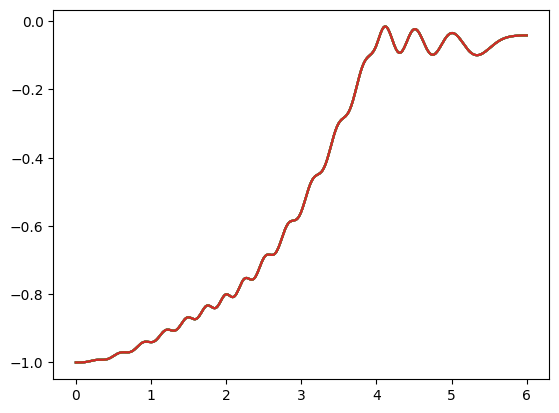

In [16]:
expect_magnetization = results.expect(magn_list)
for data in expect_magnetization:
    plt.plot(sim.evaluation_times, data)